# Engenharia de Features para Detecção de Fraude

Este notebook demonstra o processo de engenharia de features para o projeto de detecção de fraude em transações de cartão de crédito. Vamos transformar os dados brutos em features relevantes que possam melhorar o desempenho dos modelos de machine learning.

## Conteúdo
1. [Configuração do Ambiente](#1.-Configuração-do-Ambiente)
2. [Carregamento dos Dados](#2.-Carregamento-dos-Dados)
3. [Extração de Componentes Temporais](#3.-Extração-de-Componentes-Temporais)
4. [Cálculo da Distância Cliente-Comerciante](#4.-Cálculo-da-Distância-Cliente-Comerciante)
5. [Extração de Características dos Dígitos](#5.-Extração-de-Características-dos-Dígitos)
6. [Cálculo de Velocidade entre Transações](#6.-Cálculo-de-Velocidade-entre-Transações)
7. [Detecção de Desvios do Padrão de Gastos](#7.-Detecção-de-Desvios-do-Padrão-de-Gastos)
8. [Criação da Coluna Idade](#8.-Criação-da-Coluna-Idade)
9. [Normalização e One-Hot Encoding](#9.-Normalização-e-One-Hot-Encoding)
10. [Balanceamento dos Dados](#10.-Balanceamento-dos-Dados)
11. [Salvando os Dados Processados](#11.-Salvando-os-Dados-Processados)
12. [Conclusões](#12.-Conclusões)

## 1. Configuração do Ambiente

Vamos importar as bibliotecas necessárias e configurar o ambiente para nossa análise.

In [1]:
# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import math
import os
import sys
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Configurações de visualização
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Configurar exibição de dados no pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Ignorar warnings
import warnings
warnings.filterwarnings('ignore')

## 2. Carregamento dos Dados

Vamos carregar os conjuntos de dados de treino e teste para nossa análise.

In [2]:
# Definir caminhos para os arquivos
# Ajuste os caminhos conforme necessário para seu ambiente
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
data_dir = os.path.join(base_dir, 'data')
raw_dir = os.path.join(data_dir, 'raw')
processed_dir = os.path.join(data_dir, 'processed')

# Garantir que o diretório processed existe
os.makedirs(processed_dir, exist_ok=True)

train_path = os.path.join(raw_dir, 'fraudTrain.csv')
test_path = os.path.join(raw_dir, 'fraudTest.csv')

# Verificar se os arquivos existem
if not os.path.exists(train_path) or not os.path.exists(test_path):
    print(f"Erro: Arquivos não encontrados em {raw_dir}")
    print("Por favor, coloque os arquivos 'fraudTrain.csv' e 'fraudTest.csv' no diretório 'data/raw'")
else:
    # Carregar os dados
    print("Carregando dados...")
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    
    print(f"Conjunto de treino: {train_df.shape[0]} linhas, {train_df.shape[1]} colunas")
    print(f"Conjunto de teste: {test_df.shape[0]} linhas, {test_df.shape[1]} colunas")

Carregando dados...
Conjunto de treino: 1296675 linhas, 23 colunas
Conjunto de teste: 555719 linhas, 23 colunas


In [3]:
train_df.drop('Unnamed: 0', axis=1, inplace=True)
test_df.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
# Verificar valores ausentes
train_missing = train_df.isnull().sum()
train_missing = train_missing[train_missing > 0]

test_missing = test_df.isnull().sum()
test_missing = test_missing[test_missing > 0]

if len(train_missing) > 0:
    print("Valores ausentes no conjunto de treino:")
    print(train_missing)
else:
    print("Não há valores ausentes no conjunto de treino.")
    
if len(test_missing) > 0:
    print("\nValores ausentes no conjunto de teste:")
    print(test_missing)
else:
    print("Não há valores ausentes no conjunto de teste.")

Não há valores ausentes no conjunto de treino.
Não há valores ausentes no conjunto de teste.


## 3. Extração de Componentes Temporais

Vamos extrair componentes temporais úteis da data e hora da transação, como hora do dia, dia da semana e mês.

In [6]:
# Função para extrair características temporais
def extract_temporal_features(df):
    # Criar cópia para não modificar o original
    df_new = df.copy()

    # Converter a coluna transaction_date para datetime
    df_new['transaction_timestamp'] = pd.to_datetime(df_new['trans_date_trans_time'])

    # Extrair componentes de data e hora
    df_new['hour_of_day'] = df_new['transaction_timestamp'].dt.hour
    df_new['day_of_week'] = df_new['transaction_timestamp'].dt.dayofweek
    df_new['month'] = df_new['transaction_timestamp'].dt.month

    # Converter timestamp para unix time (segundos desde 1970-01-01)
    # Corrigido: converter primeiro para int64 e depois para int
    df_new['unix_time'] = df_new['transaction_timestamp'].astype('int64').astype(int) // 10**9

    return df_new

# Aplicar a função aos conjuntos de treino e teste
train_df = extract_temporal_features(train_df)
test_df = extract_temporal_features(test_df)

# Visualizar as novas colunas

# Visualizar as novas colunas
train_df[['trans_date_trans_time', 'transaction_timestamp', 'hour_of_day', 'day_of_week', 'month', 'unix_time']].head()

,trans_date_trans_time,transaction_timestamp,hour_of_day,day_of_week,month,unix_time
0,2019-01-01 00:00:18,2019-01-01 00:00:18,0,1,1,-2
1,2019-01-01 00:00:44,2019-01-01 00:00:44,0,1,1,-1
2,2019-01-01 00:00:51,2019-01-01 00:00:51,0,1,1,1
3,2019-01-01 00:01:16,2019-01-01 00:01:16,0,1,1,1
4,2019-01-01 00:03:06,2019-01-01 00:03:06,0,1,1,-1


## 4. Cálculo da Distância Cliente-Comerciante

Vamos calcular a distância entre o cliente e o comerciante usando a fórmula de Haversine, que considera a curvatura da Terra.

In [7]:
# Função para calcular a distância Haversine entre dois pontos
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calcula a distância Haversine entre dois pontos em km
    """
    # Converter graus para radianos
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Fórmula de Haversine
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Raio da Terra em quilômetros
    
    return c * r

# Aplicar a função aos conjuntos de treino e teste
train_df['distance_km'] = haversine_distance(
    train_df['lat'].values, train_df['long'].values,
    train_df['merch_lat'].values, train_df['merch_long'].values
)

test_df['distance_km'] = haversine_distance(
    test_df['lat'].values, test_df['long'].values,
    test_df['merch_lat'].values, test_df['merch_long'].values
)

# Visualizar estatísticas da distância
print("Estatísticas da distância cliente-comerciante (km):")
print(train_df['distance_km'].describe())

Estatísticas da distância cliente-comerciante (km):
count   1296675.00
mean         76.11
std          29.12
min           0.02
25%          55.33
50%          78.23
75%          98.50
max         152.12
Name: distance_km, dtype: float64


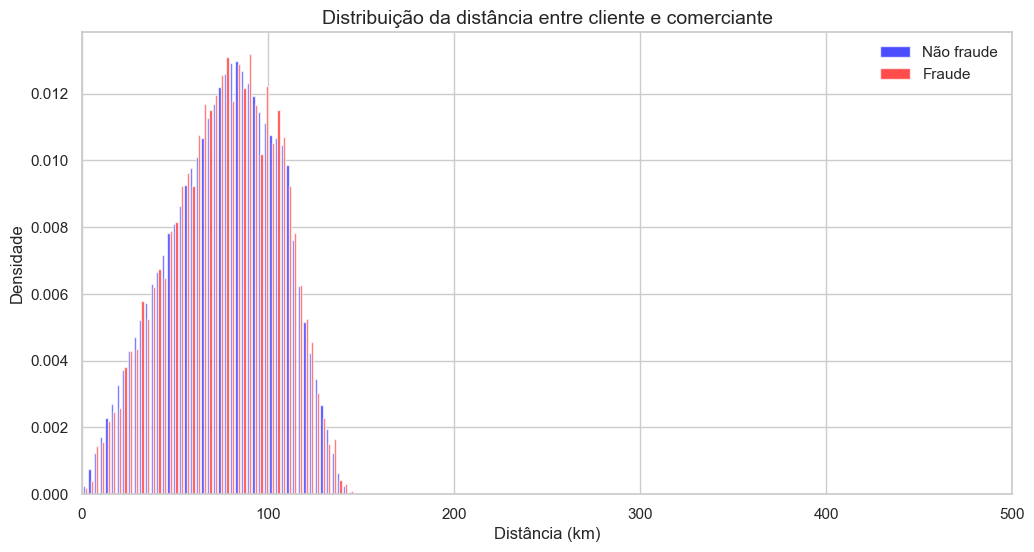

In [9]:
# Visualizar a distribuição das distâncias por classe
plt.figure(figsize=(12, 6))

# Separar por classe
distances_fraud = train_df[train_df['is_fraud'] == 1]['distance_km']
distances_non_fraud = train_df[train_df['is_fraud'] == 0]['distance_km']

# Plotar histogramas
plt.hist([distances_non_fraud, distances_fraud], bins=50, 
         label=['Não fraude', 'Fraude'], alpha=0.7,
         color=['blue', 'red'], density=True)

plt.title('Distribuição da distância entre cliente e comerciante', fontsize=14)
plt.xlabel('Distância (km)', fontsize=12)
plt.ylabel('Densidade', fontsize=12)
plt.legend()
plt.xlim(0, 500)  # Limitar para melhor visualização
plt.show()

## 5. Extração de Características dos Dígitos

Vamos extrair o primeiro e o último dígito dos valores de transação, que podem revelar padrões interessantes.

In [10]:
# Função para extrair características dos dígitos
def extract_digit_features(df):
    # Criar cópia para não modificar o original
    df_new = df.copy()
    
    # Converter valor para string
    df_new['amt_str'] = df_new['amt'].astype(str)
    
    # Primeiro dígito (não zero)
    df_new['first_digit'] = df_new['amt_str'].str.replace(r'^0+', '').str[0].astype(int)
    
    # Último dígito
    df_new['last_digit'] = df_new['amt_str'].str[-1].astype(int)
    
    return df_new

# Aplicar a função aos conjuntos de treino e teste
train_df = extract_digit_features(train_df)
test_df = extract_digit_features(test_df)

# Visualizar as novas colunas
train_df[['amt', 'amt_str', 'first_digit', 'last_digit']].head()

,amt,amt_str,first_digit,last_digit
0,4.97,4.97,4,7
1,107.23,107.23,1,3
2,220.11,220.11,2,1
3,45.00,45.0,4,0
4,41.96,41.96,4,6


<Figure size 1200x600 with 0 Axes>

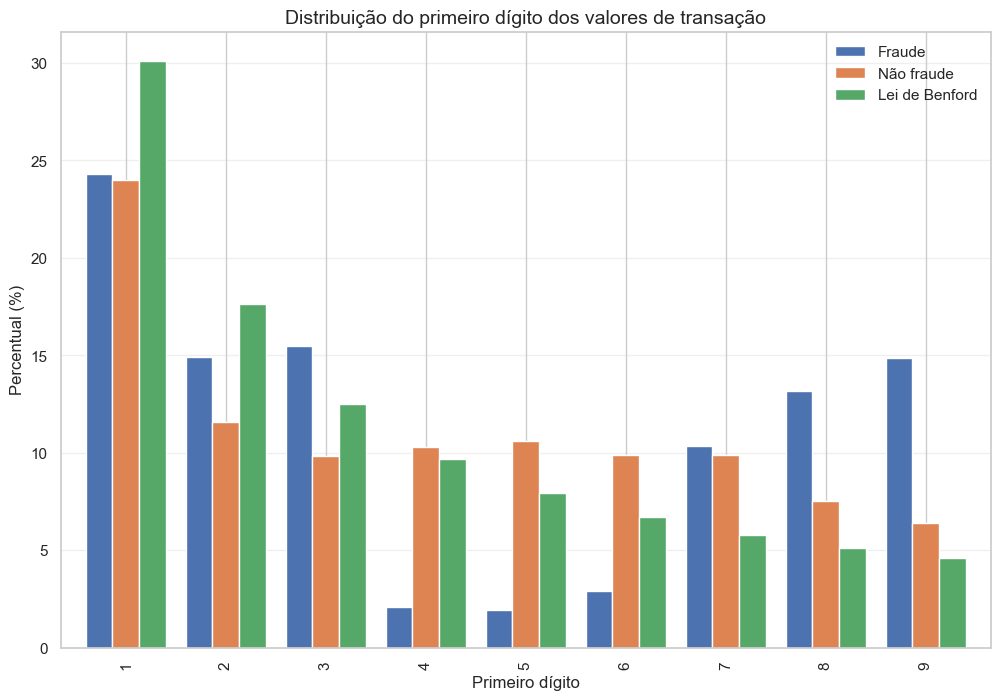

In [11]:
# Visualizar a distribuição do primeiro dígito por classe
plt.figure(figsize=(12, 6))

# Calcular percentuais
first_digit_fraud = train_df[train_df['is_fraud'] == 1]['first_digit'].value_counts(normalize=True).sort_index() * 100
first_digit_non_fraud = train_df[train_df['is_fraud'] == 0]['first_digit'].value_counts(normalize=True).sort_index() * 100

# Lei de Benford (distribuição esperada do primeiro dígito)
benford = pd.Series([np.log10(1 + 1/d) * 100 for d in range(1, 10)], index=range(1, 10))

# Criar DataFrame para plotagem
first_digit_df = pd.DataFrame({
    'Fraude': first_digit_fraud,
    'Não fraude': first_digit_non_fraud,
    'Lei de Benford': benford
})

# Plotar
first_digit_df.plot(kind='bar', width=0.8)
plt.title('Distribuição do primeiro dígito dos valores de transação', fontsize=14)
plt.xlabel('Primeiro dígito', fontsize=12)
plt.ylabel('Percentual (%)', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

## 6. Cálculo de Velocidade entre Transações

Vamos calcular a velocidade entre transações consecutivas do mesmo cartão, o que pode ajudar a identificar padrões impossíveis fisicamente.

In [12]:
# Função para calcular velocidade entre transações
def calculate_transaction_velocity(df):
    # Criar cópia para não modificar o original
    df_new = df.copy()
    
    # Ordenar transações por cartão e timestamp
    df_new = df_new.sort_values(['cc_num', 'transaction_timestamp'])
    
    # Agrupar por cartão
    grouped = df_new.groupby('cc_num')
    
    # Obter localização e timestamp da transação anterior
    df_new['prev_lat'] = grouped['lat'].shift(1)
    df_new['prev_long'] = grouped['long'].shift(1)
    df_new['prev_unix_time'] = grouped['unix_time'].shift(1)
    
    # Calcular tempo entre transações em horas
    df_new['time_diff_hours'] = (df_new['unix_time'] - df_new['prev_unix_time']) / 3600
    
    # Calcular distância entre transações consecutivas
    mask = (~df_new['prev_lat'].isna()) & (~df_new['prev_long'].isna())
    df_new.loc[mask, 'transaction_distance_km'] = haversine_distance(
        df_new.loc[mask, 'lat'].values, 
        df_new.loc[mask, 'long'].values,
        df_new.loc[mask, 'prev_lat'].values, 
        df_new.loc[mask, 'prev_long'].values
    )
    
    # Calcular velocidade (km/h)
    mask = (mask) & (df_new['time_diff_hours'] > 0)
    df_new.loc[mask, 'transaction_velocity_kmh'] = (
        df_new.loc[mask, 'transaction_distance_km'] / df_new.loc[mask, 'time_diff_hours']
    )
    
    # Flag para velocidades fisicamente impossíveis (> 1000 km/h)
    df_new['impossible_velocity'] = np.where(df_new['transaction_velocity_kmh'] > 1000, 1, 0)
    
    return df_new

# Aplicar a função aos conjuntos de treino e teste
train_df = calculate_transaction_velocity(train_df)
test_df = calculate_transaction_velocity(test_df)

# Visualizar as novas colunas
cols = ['cc_num', 'transaction_timestamp', 'lat', 'long', 'prev_lat', 'prev_long', 
        'time_diff_hours', 'transaction_distance_km', 'transaction_velocity_kmh', 'impossible_velocity']
train_df[cols].head(10)

,cc_num,transaction_timestamp,lat,long,prev_lat,prev_long,time_diff_hours,transaction_distance_km,transaction_velocity_kmh,impossible_velocity
1017,60416207185,2019-01-01 12:47:15,43.00,-108.90,NaN,NaN,NaN,NaN,NaN,0
2724,60416207185,2019-01-02 08:44:57,43.00,-108.90,43.00,-108.90,-0.00,0.00,NaN,0
2726,60416207185,2019-01-02 08:47:36,43.00,-108.90,43.00,-108.90,0.00,0.00,NaN,0
2882,60416207185,2019-01-02 12:38:14,43.00,-108.90,43.00,-108.90,-0.00,0.00,NaN,0
2907,60416207185,2019-01-02 13:10:46,43.00,-108.90,43.00,-108.90,0.00,0.00,0.00,0
4135,60416207185,2019-01-03 13:56:35,43.00,-108.90,43.00,-108.90,-0.00,0.00,NaN,0
4337,60416207185,2019-01-03 17:05:10,43.00,-108.90,43.00,-108.90,0.00,0.00,0.00,0
5467,60416207185,2019-01-04 13:59:55,43.00,-108.90,43.00,-108.90,-0.00,0.00,NaN,0
6027,60416207185,2019-01-04 21:17:22,43.00,-108.90,43.00,-108.90,0.00,0.00,0.00,0
6273,60416207185,2019-01-05 00:42:24,43.00,-108.90,43.00,-108.90,0.00,0.00,0.00,0


Relação entre velocidade impossível e fraude:
is_fraud                0    1
impossible_velocity           
0                   99.42 0.58


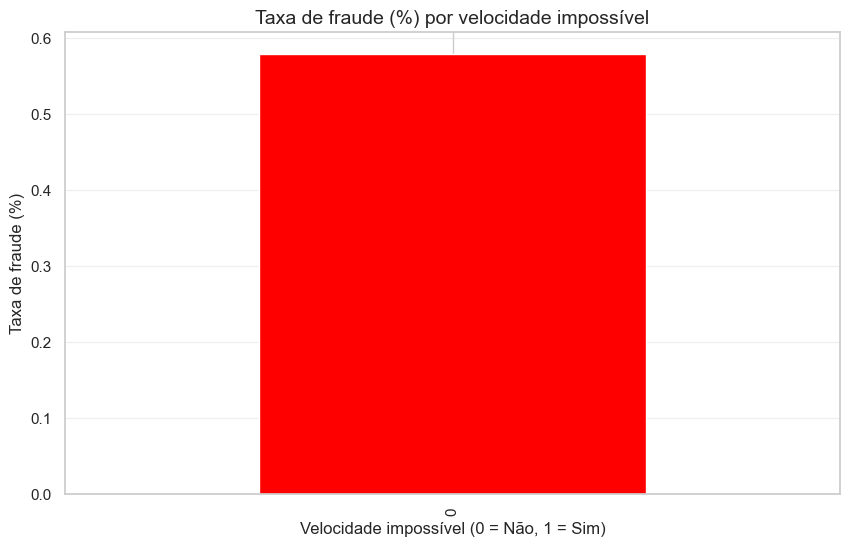

In [13]:
# Analisar a relação entre velocidade impossível e fraude
velocity_fraud = pd.crosstab(train_df['impossible_velocity'], train_df['is_fraud'], 
                            normalize='index') * 100

print("Relação entre velocidade impossível e fraude:")
print(velocity_fraud)

# Plotar
plt.figure(figsize=(10, 6))
velocity_fraud[1].plot(kind='bar', color='red')
plt.title('Taxa de fraude (%) por velocidade impossível', fontsize=14)
plt.xlabel('Velocidade impossível (0 = Não, 1 = Sim)', fontsize=12)
plt.ylabel('Taxa de fraude (%)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()

## 7. Detecção de Desvios do Padrão de Gastos

Vamos calcular desvios do padrão de gastos por cartão, o que pode ajudar a identificar transações anômalas.

In [14]:
# Função para calcular desvios do padrão de gastos
def calculate_spending_patterns(df):
    # Criar cópia para não modificar o original
    df_new = df.copy()
    
    # Calcular média e desvio padrão dos gastos por cartão
    card_stats = df_new.groupby('cc_num')['amt'].agg(['mean', 'std']).reset_index()
    card_stats.columns = ['cc_num', 'avg_amt', 'stddev_amt']
    
    # Juntar com o dataframe original
    df_new = pd.merge(df_new, card_stats, on='cc_num', how='left')
    
    # Calcular z-score do valor da transação
    df_new['amt_zscore'] = np.where(
        (df_new['stddev_amt'].notna()) & (df_new['stddev_amt'] > 0),
        (df_new['amt'] - df_new['avg_amt']) / df_new['stddev_amt'],
        0
    )
    
    # Flag para valores atípicos (|z-score| > 3)
    df_new['amt_is_outlier'] = np.where(np.abs(df_new['amt_zscore']) > 3, 1, 0)
    
    return df_new

# Aplicar a função aos conjuntos de treino e teste
train_df = calculate_spending_patterns(train_df)
test_df = calculate_spending_patterns(test_df)

# Visualizar as novas colunas
cols = ['cc_num', 'amt', 'avg_amt', 'stddev_amt', 'amt_zscore', 'amt_is_outlier', 'is_fraud']
train_df[cols].head(10)

,cc_num,amt,avg_amt,stddev_amt,amt_zscore,amt_is_outlier,is_fraud
0,60416207185,7.27,56.02,122.63,-0.40,0,0
1,60416207185,52.94,56.02,122.63,-0.03,0,0
2,60416207185,82.08,56.02,122.63,0.21,0,0
3,60416207185,34.79,56.02,122.63,-0.17,0,0
4,60416207185,27.18,56.02,122.63,-0.24,0,0
5,60416207185,6.87,56.02,122.63,-0.40,0,0
6,60416207185,8.43,56.02,122.63,-0.39,0,0
7,60416207185,117.11,56.02,122.63,0.50,0,0
8,60416207185,26.74,56.02,122.63,-0.24,0,0
9,60416207185,105.20,56.02,122.63,0.40,0,0


Relação entre valores atípicos e fraude:
is_fraud           0     1
amt_is_outlier            
0              99.66  0.34
1              83.03 16.97


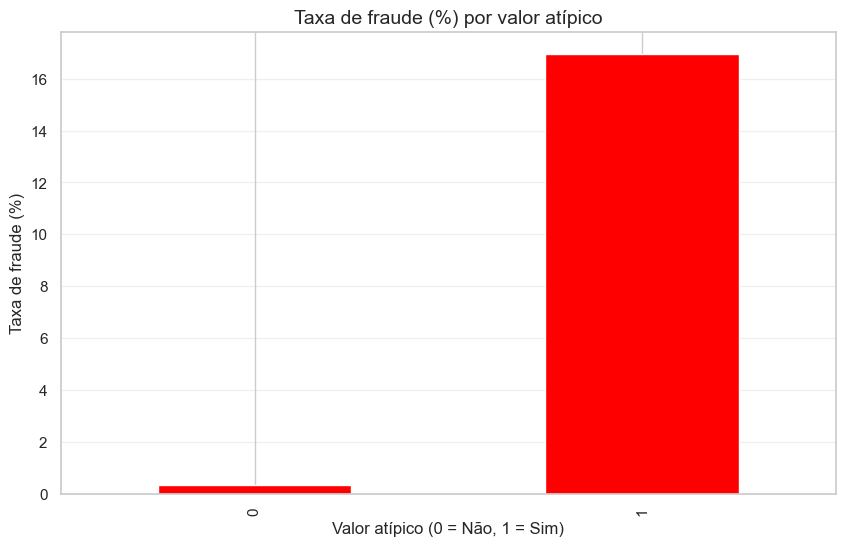

In [15]:
# Analisar a relação entre valores atípicos e fraude
outlier_fraud = pd.crosstab(train_df['amt_is_outlier'], train_df['is_fraud'], 
                           normalize='index') * 100

print("Relação entre valores atípicos e fraude:")
print(outlier_fraud)

# Plotar
plt.figure(figsize=(10, 6))
outlier_fraud[1].plot(kind='bar', color='red')
plt.title('Taxa de fraude (%) por valor atípico', fontsize=14)
plt.xlabel('Valor atípico (0 = Não, 1 = Sim)', fontsize=12)
plt.ylabel('Taxa de fraude (%)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()

## 8. Criação da Coluna Idade

Vamos criar a coluna "Idade" a partir da data de nascimento (dob).

In [20]:
# Função para calcular idade a partir da data de nascimento
def calculate_age(dob_str):
    """
    Calcula a idade a partir da data de nascimento
    """
    try:
        # Converter string para datetime
        dob = datetime.strptime(dob_str, '%Y-%m-%d')
        
        # Data de referência (usamos a data mais recente do conjunto de dados)
        # Assumindo que a data mais recente é 2021-01-01
        reference_date = datetime(2021, 1, 1)
        
        # Calcular idade
        age = reference_date.year - dob.year
        
        # Ajustar se ainda não fez aniversário neste ano
        if (reference_date.month, reference_date.day) < (dob.month, dob.day):
            age -= 1
            
        return age
    except:
        return np.nan

# Aplicar a função aos conjuntos de treino e teste
train_df['idade'] = train_df['dob'].apply(calculate_age)
test_df['idade'] = test_df['dob'].apply(calculate_age)

# Visualizar as novas colunas
train_df[['dob', 'idade']].head()

,dob,idade
0,1986-02-17,34
1,1986-02-17,34
2,1986-02-17,34
3,1986-02-17,34
4,1986-02-17,34


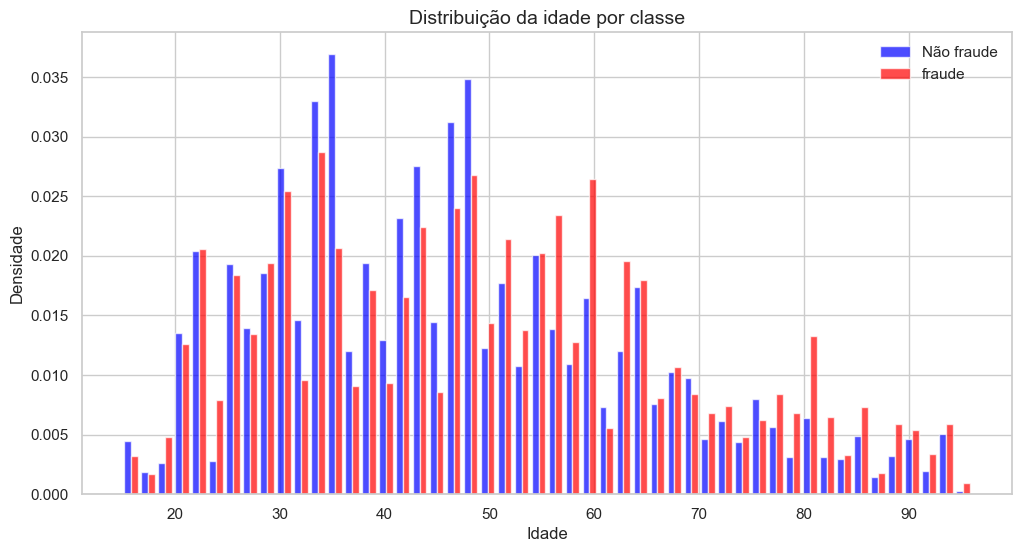

Estatísticas de idade para transações não fraudulentas:
count   1289169.00
mean         46.73
std          17.37
min          15.00
25%          33.00
50%          45.00
75%          58.00
max          96.00
Name: idade, dtype: float64

Estatísticas de idade para transações fraudulentas:
count   7506.00
mean      49.56
std       18.84
min       15.00
25%       34.00
50%       48.00
75%       62.00
max       95.00
Name: idade, dtype: float64


In [22]:
# Analisar a distribuição da idade
plt.figure(figsize=(12, 6))

# Separar por classe
age_fraud = train_df[train_df['is_fraud'] == 1]['idade']
age_non_fraud = train_df[train_df['is_fraud'] == 0]['idade']

# Plotar histogramas
plt.hist([age_non_fraud, age_fraud], bins=50, 
         label=['Não fraude', 'fraude'], alpha=0.7,
         color=['blue', 'red'], density=True)

plt.title('Distribuição da idade por classe', fontsize=14)
plt.xlabel('Idade', fontsize=12)
plt.ylabel('Densidade', fontsize=12)
plt.legend()
plt.show()

# Estatísticas da idade
print("Estatísticas de idade para transações não fraudulentas:")
print(age_non_fraud.describe())
print("\nEstatísticas de idade para transações fraudulentas:")
print(age_fraud.describe())

## 9. Normalização e One-Hot Encoding

Vamos aplicar normalização às colunas numéricas especificadas e one-hot encoding às colunas categóricas especificadas.

In [24]:
# Definir colunas para transformação
categorical_cols = ['gender', 'job', 'city']
numeric_cols_to_normalize = [
    # 'zip', 'lat', 'long',
    # 'city_pop', 'unix_time',
    # 'merch_lat', 'merch_long', 'distance_km',
    # 'prev_lat', 'prev_long', 'prev_unix_time', 'time_diff_hours'
]
numeric_cols_no_normalize = [
    'amt', 'hour_of_day', 'day_of_week', 'month', 
    'first_digit', 'last_digit', 'transaction_velocity_kmh', 
    'impossible_velocity', 'avg_amt', 'stddev_amt', 
    'amt_zscore', 'amt_is_outlier', 'idade',
    'lat', 'long',
    'city_pop', 'unix_time',
    'merch_lat', 'merch_long', 'distance_km',
    'prev_lat', 'prev_long', 'prev_unix_time', 'time_diff_hours'
]

print(f"Colunas categóricas para one-hot encoding: {categorical_cols}")
print(f"Colunas numéricas para normalização: {numeric_cols_to_normalize}")
print(f"Colunas numéricas sem normalização: {numeric_cols_no_normalize}")

Colunas categóricas para one-hot encoding: ['gender', 'job', 'city']
Colunas numéricas para normalização: []
Colunas numéricas sem normalização: ['amt', 'hour_of_day', 'day_of_week', 'month', 'first_digit', 'last_digit', 'transaction_velocity_kmh', 'impossible_velocity', 'avg_amt', 'stddev_amt', 'amt_zscore', 'amt_is_outlier', 'idade', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long', 'distance_km', 'prev_lat', 'prev_long', 'prev_unix_time', 'time_diff_hours']


In [25]:
# Função para aplicar normalização e one-hot encoding
def apply_transformations(train_df, test_df, categorical_cols, numeric_cols_to_normalize):
    # Criar cópias para não modificar os originais
    train_transformed = train_df.copy()
    test_transformed = test_df.copy()
    
    # 1. Normalização de colunas numéricas
    if numeric_cols_to_normalize:
        print(f"Normalizando colunas numéricas: {numeric_cols_to_normalize}")
        
        # Inicializar e ajustar o scaler
        scaler = StandardScaler()
        scaler.fit(train_df[numeric_cols_to_normalize])
        
        # Transformar dados de treino e teste
        train_scaled = scaler.transform(train_df[numeric_cols_to_normalize])
        test_scaled = scaler.transform(test_df[numeric_cols_to_normalize])
        
        # Converter arrays para DataFrames
        train_scaled_df = pd.DataFrame(
            train_scaled, 
            columns=[f"{col}_scaled" for col in numeric_cols_to_normalize],
            index=train_df.index
        )
        
        test_scaled_df = pd.DataFrame(
            test_scaled, 
            columns=[f"{col}_scaled" for col in numeric_cols_to_normalize],
            index=test_df.index
        )
        
        # Concatenar com os DataFrames originais
        train_transformed = pd.concat([train_transformed, train_scaled_df], axis=1)
        test_transformed = pd.concat([test_transformed, test_scaled_df], axis=1)
    
    # 2. One-hot encoding de colunas categóricas
    if categorical_cols:
        print(f"Aplicando one-hot encoding nas colunas: {categorical_cols}")
        
        # Inicializar e ajustar o encoder
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoder.fit(train_df[categorical_cols])
        
        # Transformar dados de treino e teste
        train_encoded = encoder.transform(train_df[categorical_cols])
        test_encoded = encoder.transform(test_df[categorical_cols])
        
        # Obter nomes das colunas codificadas
        encoded_feature_names = []
        for i, col in enumerate(categorical_cols):
            categories = encoder.categories_[i]
            for cat in categories:
                encoded_feature_names.append(f"{col}_{cat}")
        
        # Converter arrays para DataFrames
        train_encoded_df = pd.DataFrame(
            train_encoded, 
            columns=encoded_feature_names,
            index=train_df.index
        )
        
        test_encoded_df = pd.DataFrame(
            test_encoded, 
            columns=encoded_feature_names,
            index=test_df.index
        )
        
        # Concatenar com os DataFrames transformados
        train_transformed = pd.concat([train_transformed, train_encoded_df], axis=1)
        test_transformed = pd.concat([test_transformed, test_encoded_df], axis=1)
    
    return train_transformed, test_transformed

# Aplicar transformações
train_transformed, test_transformed = apply_transformations(
    train_df, test_df, categorical_cols, numeric_cols_to_normalize
)

Aplicando one-hot encoding nas colunas: ['gender', 'job', 'city']


In [26]:
# Verificar as colunas transformadas
# Colunas normalizadas
scaled_cols = [col for col in train_transformed.columns if col.endswith('_scaled')]
print(f"Colunas normalizadas: {len(scaled_cols)}")
print(scaled_cols[:5], '...', scaled_cols[-5:] if len(scaled_cols) > 5 else '')

# Colunas one-hot encoded
encoded_cols = []
for col in train_transformed.columns:
    for cat_col in categorical_cols:
        if col.startswith(f"{cat_col}_") and col != f"{cat_col}_scaled":
            encoded_cols.append(col)
            
print(f"\nColunas one-hot encoded: {len(encoded_cols)}")
print(encoded_cols[:5], '...', encoded_cols[-5:] if len(encoded_cols) > 5 else '')

Colunas normalizadas: 0
[] ... 

Colunas one-hot encoded: 1391
['city_pop', 'gender_F', 'gender_M', 'job_Academic librarian', 'job_Accountant, chartered'] ... ['city_Woods Cross', 'city_Woodville', 'city_Yellowstone National Park', 'city_Zaleski', 'city_Zavalla']


## 10. Balanceamento dos Dados

Vamos balancear os dados de treino usando undersampling da classe majoritária.

In [27]:
# Função para balancear os dados
def balance_data(df, target_col='is_fraud', ratio=10):
    """
    Balanceia os dados usando undersampling da classe majoritária
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame para balancear
    target_col : str
        Nome da coluna alvo
    ratio : int
        Proporção desejada entre classes (majoritária:minoritária)
        
    Returns:
    --------
    DataFrame
        DataFrame balanceado
    """
    # Separar classes
    fraud_df = df[df[target_col] == 1]
    non_fraud_df = df[df[target_col] == 0]
    
    fraud_count = len(fraud_df)
    non_fraud_count = len(non_fraud_df)
    
    print(f"Transações fraudulentas: {fraud_count}")
    print(f"Transações não fraudulentas: {non_fraud_count}")
    print(f"Proporção original: 1:{non_fraud_count/fraud_count:.1f}")
    
    # Definir tamanho da amostra para a classe majoritária
    sample_size = min(fraud_count * ratio, non_fraud_count)
    
    # Realizar undersampling da classe majoritária
    non_fraud_sample = non_fraud_df.sample(n=sample_size, random_state=42)
    
    # Combinar para criar conjunto balanceado
    balanced_df = pd.concat([fraud_df, non_fraud_sample])
    
    print(f"Transações não fraudulentas após undersampling: {len(non_fraud_sample)}")
    print(f"Nova proporção: 1:{len(non_fraud_sample)/fraud_count:.1f}")
    print(f"Total de transações após balanceamento: {len(balanced_df)}")
    
    return balanced_df

# Aplicar balanceamento aos dados de treino
train_balanced = balance_data(train_transformed)

Transações fraudulentas: 7506
Transações não fraudulentas: 1289169
Proporção original: 1:171.8
Transações não fraudulentas após undersampling: 75060
Nova proporção: 1:10.0
Total de transações após balanceamento: 82566


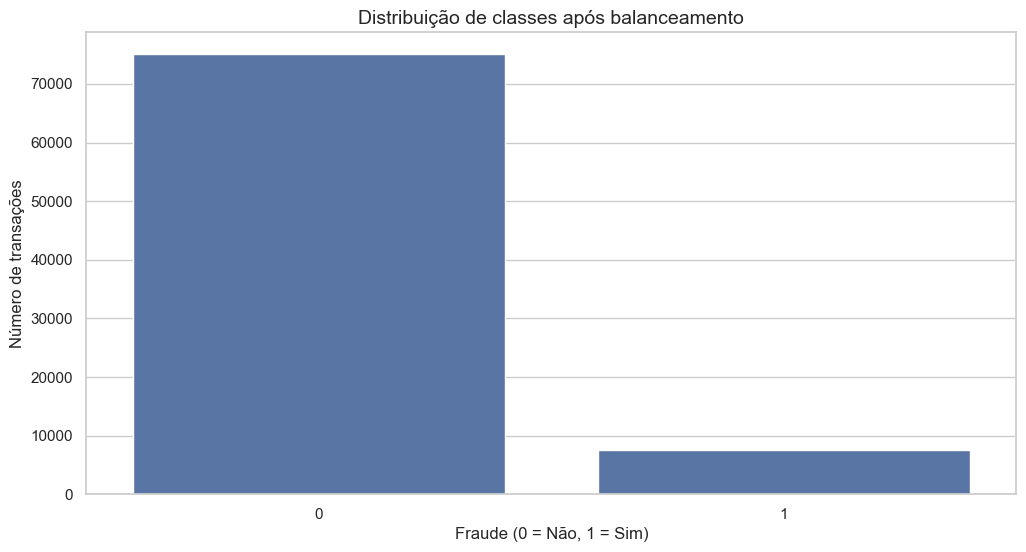

In [28]:
    # Visualizar a distribuição das classes após o balanceamento
plt.figure(figsize=(12, 6))
sns.countplot(x='is_fraud', data=train_balanced)
plt.title('Distribuição de classes após balanceamento', fontsize=14)
plt.xlabel('Fraude (0 = Não, 1 = Sim)', fontsize=12)
plt.ylabel('Número de transações', fontsize=12)
plt.show()

## 11. Salvando os Dados Processados

Vamos salvar os dados processados para uso posterior na modelagem.

In [36]:
# Preparar features para modelagem
def prepare_features_for_modeling(train_df, test_df, categorical_cols, numeric_cols_to_normalize, numeric_cols_no_normalize):
    """
    Prepara as features para modelagem, incluindo seleção de colunas relevantes
    """
    print("\nPreparando features para modelagem...")

    
    # Identificar colunas codificadas (one-hot encoding)
    encoded_cols = []
    for col in train_df.columns:
        for cat_col in categorical_cols:
            if col.startswith(f"{cat_col}_") and col != f"{cat_col}_scaled":
                encoded_cols.append(col)
    
    # Identificar colunas normalizadas
    scaled_cols = [f"{col}_scaled" for col in numeric_cols_to_normalize]
    
    # Combinar todas as features para modelagem
    feature_cols = encoded_cols + scaled_cols + numeric_cols_no_normalize
    
    # Remover a coluna alvo se estiver nas features
    if 'is_fraud' in feature_cols:
        feature_cols.remove('is_fraud')
    
    print(f"Total de features para modelagem: {len(feature_cols)}")
    
    # Separar features e target
    X_train = train_df[feature_cols]
    y_train = train_df['is_fraud']
    
    X_test = test_df[feature_cols]
    y_test = test_df['is_fraud']
    
    return X_train, y_train, X_test, y_test, feature_cols

# Preparar features para modelagem
X_train, y_train, X_test, y_test, feature_cols = prepare_features_for_modeling(
    train_balanced, test_transformed, 
    categorical_cols, numeric_cols_to_normalize, numeric_cols_no_normalize
)


Preparando features para modelagem...
Total de features para modelagem: 1415


MemoryError: Unable to allocate 5.76 GiB for an array with shape (1390, 555719) and data type float64

In [41]:
# Salvar dados processados
print("\nSalvando dados processados...")

# Salvar dados transformados
train_balanced.to_csv(os.path.join(processed_dir, 'train_transformed.csv'), index=False)
test_transformed.to_csv(os.path.join(processed_dir, 'test_transformed.csv'), index=False)

# Salvar features e targets para modelagem
X_train.to_csv(os.path.join(processed_dir, 'X_train.csv'), index=False)
y_train.to_csv(os.path.join(processed_dir, 'y_train.csv'), index=False)
X_test.to_csv(os.path.join(processed_dir, 'X_test.csv'), index=False)
y_test.to_csv(os.path.join(processed_dir, 'y_test.csv'), index=False)

# Salvar lista de features
with open(os.path.join(processed_dir, 'feature_cols.txt'), 'w') as f:
    for col in feature_cols:
        f.write(f"{col}\n")

print("Dados processados salvos em:")
print(f"- {os.path.join(processed_dir, 'train_transformed.csv')}")
print(f"- {os.path.join(processed_dir, 'test_transformed.csv')}")
print(f"- {os.path.join(processed_dir, 'X_train.csv')}")
print(f"- {os.path.join(processed_dir, 'y_train.csv')}")
print(f"- {os.path.join(processed_dir, 'X_test.csv')}")
print(f"- {os.path.join(processed_dir, 'y_test.csv')}")
print(f"- {os.path.join(processed_dir, 'feature_cols.txt')}")


Salvando dados processados...
Dados processados salvos em:
- C:\Users\gabri\PycharmProjects\CASE_iFood\data\processed\train_transformed.csv
- C:\Users\gabri\PycharmProjects\CASE_iFood\data\processed\test_transformed.csv
- C:\Users\gabri\PycharmProjects\CASE_iFood\data\processed\X_train.csv
- C:\Users\gabri\PycharmProjects\CASE_iFood\data\processed\y_train.csv
- C:\Users\gabri\PycharmProjects\CASE_iFood\data\processed\X_test.csv
- C:\Users\gabri\PycharmProjects\CASE_iFood\data\processed\y_test.csv
- C:\Users\gabri\PycharmProjects\CASE_iFood\data\processed\feature_cols.txt


## 12. Conclusões

Neste notebook, realizamos uma extensa engenharia de features para o projeto de detecção de fraude em transações de cartão de crédito. Vamos resumir o que foi feito e os próximos passos.

### Resumo das Transformações Realizadas:

1. **Extração de Componentes Temporais**:
   - Hora do dia, dia da semana e mês da transação
   - Conversão para unix time para cálculos de diferença temporal

2. **Cálculo da Distância Cliente-Comerciante**:
   - Utilização da fórmula de Haversine para considerar a curvatura da Terra
   - Identificação de padrões geográficos relacionados a fraudes

3. **Extração de Características dos Dígitos**:
   - Primeiro e último dígito dos valores de transação
   - Comparação com a Lei de Benford para identificar anomalias

4. **Cálculo de Velocidade entre Transações**:
   - Identificação de velocidades fisicamente impossíveis
   - Flag para transações que ocorrem em locais distantes em curto intervalo de tempo

5. **Detecção de Desvios do Padrão de Gastos**:
   - Cálculo de média e desvio padrão dos gastos por cartão
   - Identificação de valores atípicos (outliers) usando z-score

6. **Criação da Coluna Idade**:
   - Cálculo da idade a partir da data de nascimento
   - Análise da distribuição de idade por classe

7. **Normalização e One-Hot Encoding**:
   - Normalização apenas das colunas numéricas especificadas
   - One-hot encoding apenas das colunas categóricas especificadas

8. **Balanceamento dos Dados**:
   - Undersampling da classe majoritária para equilibrar o conjunto de treino
   - Proporção de 1:10 entre transações fraudulentas e não fraudulentas

### Próximos Passos:

1. **Modelagem**:
   - Treinar diferentes algoritmos (Regressão Logística, Random Forest, Gradient Boosted Trees, XGBoost)
   - Otimizar hiperparâmetros para melhorar o desempenho

2. **Avaliação**:
   - Utilizar métricas apropriadas para dados desbalanceados (AUC-ROC, Precision, Recall, F1-Score)
   - Analisar a matriz de confusão e curvas ROC/Precision-Recall

3. **Interpretação**:
   - Analisar a importância das features para entender os principais fatores de risco
   - Extrair insights para melhorar a detecção de fraude

Os dados processados estão prontos para serem utilizados na fase de modelagem, que será abordada no próximo notebook.